### Add perpendicular and parallel coordinates to mesh datasets
we need to solve the equations over longitudinal and ordinal distances. Therefore we should ad perpendicular and parallel coordinates to each row/column combination in a mesh

In [1]:
from orprofile import api
from orprofile import profile
import geopandas as gpd
import numpy as np
import xugrid as xu
import xarray as xr

In [2]:
def compute_scalar_coordinates(ds_vector):
    """
    Compute parallel or perpendicular coordinates
    """
    dx = np.diff(ds_vector.grid.face_x)
    dy = np.diff(ds_vector.grid.face_y)
    ds = (dx**2+dy**2)**0.5
    # compute the distances
    s = np.concatenate(
        [
            np.array([0]),
            np.cumsum(ds)
        ]
    )
    return s




### Make a mesh with the existing functionalities

<GeoAxes: >

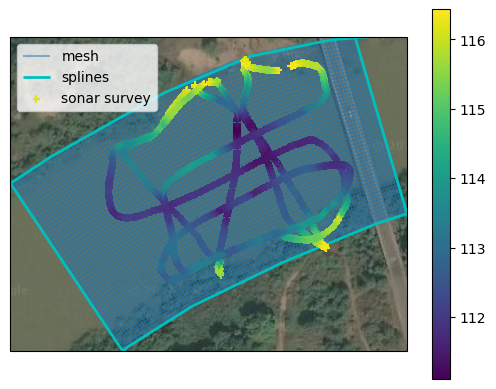

In [3]:
splines = gpd.read_file("../examples/data/splines.geojson")
fn_points = "../examples/data/bamboi_survey.geojson"

mesh = api.mesh.Mesh(splines, n=50, m=100, points=fn_points)

mesh.plot()

### Define numpy functions (for profiles) and xugrid functions for curvilinear grid applications

In [4]:
# Vector numpy functions
def deepest_point_y_dist(x, alpha, L, kappa, y_off_mean=0.):
    return y_off_mean + alpha*np.sin(2*np.pi*(x/L)-kappa)

def depth_from_width(s, phi=0.25*np.pi, h_m=10):
    """
    Simplest implementation of Eq. 12 from Savenije 2003, where the first coordinate (zero meters) is the lowest point. We stop at zero as that
    is where we reach the natural levee crest.
    """
    # zero is the lowest point in the stream starting in the middle of the stream
    angle = np.minimum(np.tan(phi)/h_m * s, 0.5*np.pi)
    depth = -np.cos(angle)*h_m
    return depth

def depth_profile_left_right_parameters(s, gamma, h_m, A, c):
    """
    we assume here that the most extreme coordinates are at more or less the same elevation and 
    within the area spanning between both natural levees (they do not have to be at the natural levee per se)
    """
    B = s[-1] - s[0]
    frac_right = 1/(1+gamma)  # TODO include the c-parameter to correct fir B_tilde and B difference.
    
    # make coordinates with zero at the deepest point negative (positive) left (right) of deepest point
    s_ordinal = s - (1-frac_right) * B
    # estimate the average depth (eq. 15 in Savenije 2003)
    h = 2*h_m / np.pi
    # solve B_r and B_l
    B_r = A/(h*(1+gamma))
    B_l = gamma*B_r
    # compute tan phi left and right
    tan_phi_left = h_m*np.pi/(2*B_l)
    tan_phi_right = h_m*np.pi/(2*B_r)
    tan_phi_right2 = gamma * tan_phi_left
    phi_left = np.arctan(tan_phi_left)
    phi_right = np.arctan(tan_phi_right)
    
    depth = np.zeros(s.shape)
    
    depth[s_ordinal < 0] = depth_from_width(-s_ordinal[s_ordinal < 0], phi=phi_left[s_ordinal < 0], h_m=h_m[s_ordinal < 0])
    depth[s_ordinal >= 0] = depth_from_width(s_ordinal[s_ordinal >= 0], phi=phi_right[s_ordinal >= 0], h_m=h_m[s_ordinal >= 0])
    # depth = depth_from_width(s_ordinal, phi=phi_left, h_m=h_m)
    # return s_ordinal
    return np.minimum(depth, 0)



# DataArray functions
def depth_profile_row(row, A, c):
    s = row.yi
    gamma = row["gamma"]
    h_m = row["h_m"]
    depth = depth_profile_left_right_parameters(s, gamma, h_m, A, c)*(h_m*0+1)
    return depth


def depth_2d(mesh, alpha, L, kappa, c, A):
    """
    
    """
    ds = mesh._get_empty_ds()
    xi = mesh.map_rowcol_wise(
        api.get_dist,
        name="xi",
        rowcol="rows"
    )
    
    yi = mesh.map_rowcol_wise(
        api.get_dist,
        name="yi",
        rowcol="cols"
    )
    ds["yi"] = yi
    ds["xi"] = yi
    

    # get the asymmetry parameter
    B_vector = ds["yi"].groupby("cols").max() - ds["yi"].groupby("cols").min()
    B_grid = np.zeros(len(ds["xi"]))
    for n, b in enumerate(B_vector.values):
        B_grid[ds["cols"] == n] = b
    

    # gamma = get_gamma(xi, yi, c, alpha, L, kappa)
    # get the h_m values
    h_m = A*np.pi/(2*c*B_grid)
    gamma = get_gamma(xi, yi, c, alpha, L, kappa, A, h_m)
    ds["h_m"] = ("mesh2d_nFaces", h_m)
    ds["gamma"] = ("mesh2d_nFaces", gamma)
    ds_g = xr.Dataset(ds).groupby("cols")
    depth = ds_g.map(
        depth_profile_row,
        # name="depth",
        # ugrid=mesh.mesh2d,
        A=A,
        c=c,
    )
    ds["depth"] = depth
    return ds


def get_gamma(xi, yi, c, alpha, L, kappa, A, h_m):
    # compute the location of the middle
    y_mean = yi.groupby("cols").mean()
    y_disti = deepest_point_y_dist(xi, alpha, L, kappa, y_off_mean=0.)

    h = 2*h_m / np.pi
    Br_vector = y_mean - yi.groupby("cols").min() + y_disti.groupby("cols").max()
    Br_grid = np.zeros(len(xi))
    for n, br in enumerate(Br_vector.values):
        Br_grid[xi["cols"] == n] = br

    # # compute the grid width (B tilde)
    # B_grid = yi[-1] - yi[0]
    # Br_grid = B_grid - (y_mean - yi[0] + y_disti.max(axis=0))

    gamma = A/(h*Br_grid*c) - 1
    # gamma = y_disti/(c*B_grid) + 1
    # then we compute how far in the transect we are per grid cell
    return gamma


### Application with some randomly selected parameters

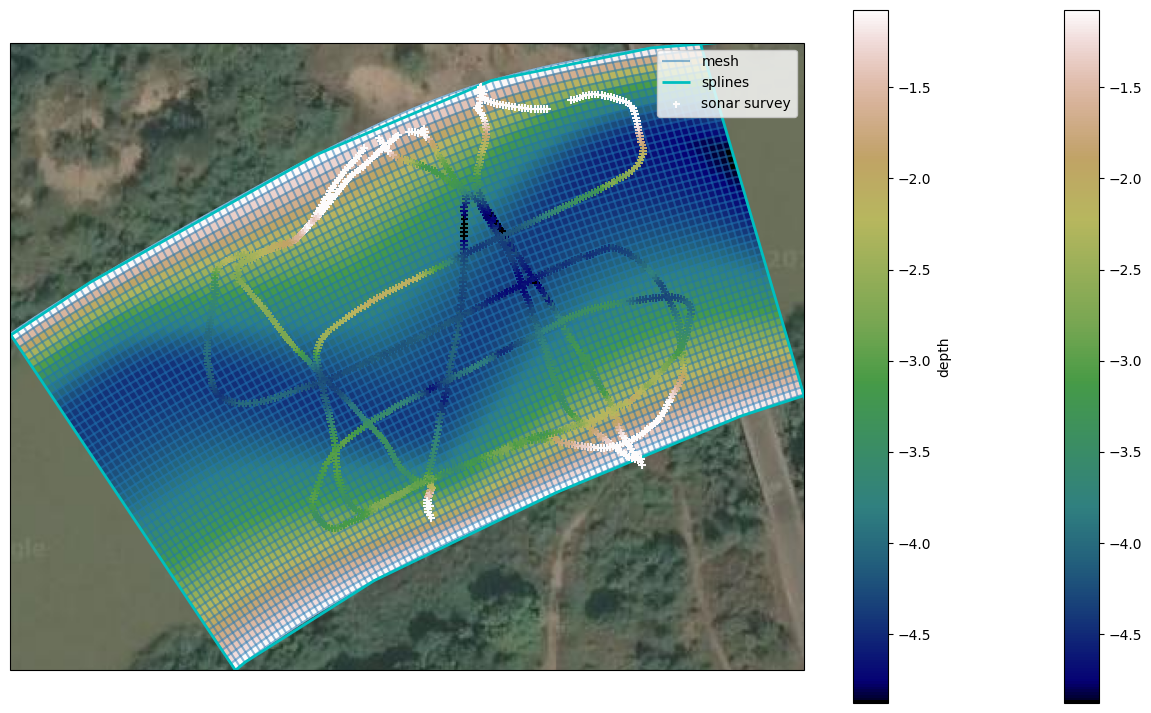

In [37]:
import matplotlib.pyplot as plt

alpha = 10  # amplitude of meander around centerline [m]
L = 200  # m
A = 350  # conveyance m2
c = 1.0  # width to grid width ratio [-]
kappa = -.25*np.pi  # phase [rad]

# optimized parameters are below
alpha, L, kappa, c, A = [10, 39.4624431, 0.204105903, 1.188, 429.690415]


# optimized large-scale parameters, smaller scale defined by user??
L = 200
kappa = -.25*np.pi  # phase [rad]
alpha = 30


ds_depth = depth_2d(mesh, alpha, L, kappa, c, A)

mesh.points["depth"] = mesh.points["Depth"] - 116.1

f = plt.figure(figsize=(16, 9))
ax = mesh.plot(points_kw={"cmap": "gist_earth", "vmin": ds_depth["depth"].min(), "vmax": ds_depth["depth"].max()})
ds_depth = ds_depth.ugrid.to_crs(ax.projection)
ds_depth["depth"].ugrid.plot(ax=ax, cmap="gist_earth")

<GeoAxes: xlabel='x', ylabel='y'>

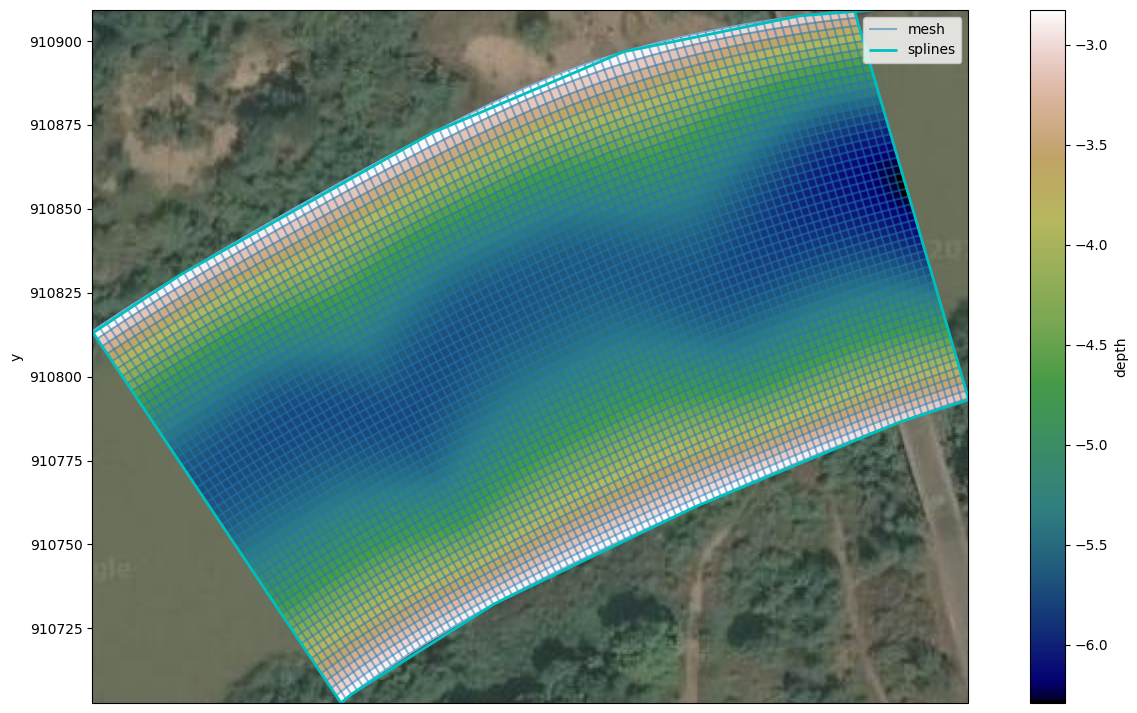

In [20]:
import cartopy.crs as ccrs
f = plt.figure(figsize=(16, 9))
ax = mesh.plot(plot_points=False)
ds_depth = ds_depth.ugrid.to_crs(ax.projection)
ds_depth["depth"].ugrid.plot(ax=ax, cmap="gist_earth")
gdf["depth"] = gdf["Depth"] - 116.2

gdf["depth"].plot(
    ax=ax,
    column="depth",
    transform=ccrs.epsg(mesh.splines.crs.to_epsg()),
    zorder=2,
    marker="+",
    # vmin=ds_depth["depth"].min(), 
    # vmax=ds_depth["depth"].max(),
    cmap="gist_earth"
)


<Axes: >

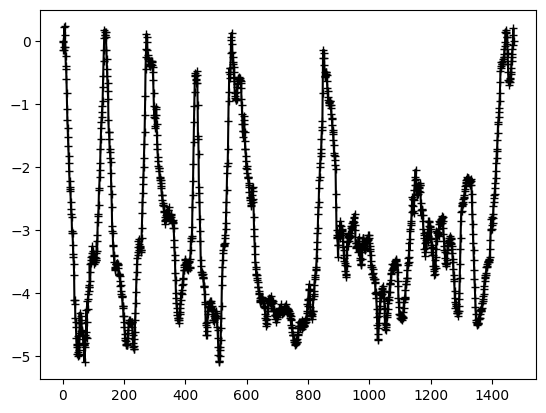

In [24]:
# ax = plt.subplot(projection=ccrs.PlateCarree())
ax = plt.subplot()
gdf["depth"].plot(
    ax=ax,
    column="depth",
    # transform=ccrs.epsg(mesh.splines.crs.to_epsg()),
    zorder=2,
    marker="+",
    # vmin=ds_depth["depth"].min(), 
    # vmax=ds_depth["depth"].max(),
    cmap="gist_earth"
)


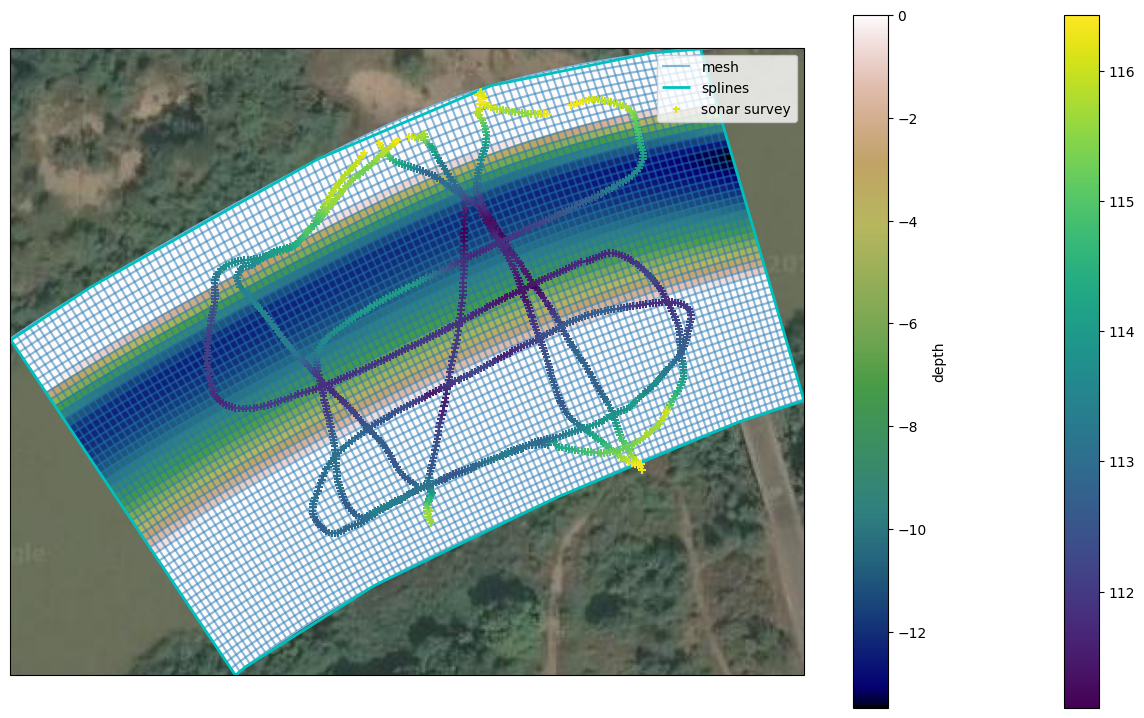

In [7]:
f = plt.figure(figsize=(16, 9))
ax = mesh.plot() #plot_points=False)
ds2 = ds2.ugrid.to_crs(ax.projection)
ds2["depth"].ugrid.plot(ax=ax, cmap="gist_earth")